# Consumption Responses

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os

processed = '/home/mitch/Dropbox/data/mexico_enigh/processed2'
os.chdir(processed)
df = pd.read_csv('data.csv')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20399 entries, 0 to 20398
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   consumption_current                                      20399 non-null  float64
 1   income_rental                                            20399 non-null  float64
 2   location                                                 20399 non-null  int64  
 3   weight                                                   20399 non-null  float64
 4   income_current                                           20399 non-null  float64
 5   income_salary                                            20399 non-null  float64
 6   financial_income                                         20399 non-null  float64
 7   financial_expenditures                                   20399 non-null  float64
 8   location_size             

In [17]:
df['post'] = df['Y'] == 1996

# Income Deciles
1. This section computes the income decile within each year

In [18]:
import statsmodels.stats.weightstats as ws
def get_deciles(x, weights=None):
    stats = ws.DescrStatsW(x, weights=weights)

    deciles =  np.arange(0.1, 1.1, .1)
    income_deciles = stats.quantile(deciles).values
    x_deciles = np.array([np.argmax(income_deciles > xi) for xi in x])
    return x_deciles + 1

print(len(df))
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')

20399


# Dummy Variables
1. This section creates dummy variables for sex, education, location, and income decile

In [19]:
dummies ={}
dummies_names = []

df['age_sq'] = df['age'] ** 2
to_dummies = ['sex', 'education', 'location_size', 'decile']

for var in to_dummies:
    print('Making dummies for', var)
    dummies[var] = pd.get_dummies(df[var], drop_first=True, prefix=var)
    dummies_names += list(dummies[var].columns)


Making dummies for sex
Making dummies for education
Making dummies for location_size
Making dummies for decile


In [20]:
for data in dummies.values():
    df = pd.concat([df, data], axis=1)

# Interaction Dummy Variables
1. This section creates interactions with the recession and education, sex, and income decile

In [21]:
df['post_education'] = df['post'] * (pd.Categorical(df.education).codes + 1)
C_post_education = pd.get_dummies(df['post_education'], prefix='post_education', drop_first=True)
C_post_education = C_post_education.drop(columns='post_education_1')
dummies_names += list(C_post_education.columns)
df = pd.concat([df, C_post_education], axis=1)

In [22]:
df['post_sex'] = df['post'] * (pd.Categorical(df.sex).codes + 1)
C_post_sex = pd.get_dummies(df['post_sex'], prefix='post_sex', drop_first=True)
C_post_sex = C_post_sex.drop(columns='post_sex_1')
dummies_names += list(C_post_sex.columns)
df = pd.concat([df, C_post_sex], axis=1)

In [23]:
df['post_decile'] = df['post'] * df['decile']
C_post_decile = pd.get_dummies(df['post_decile'], prefix='post_decile')
C_post_decile = C_post_decile.drop(columns=['post_decile_0'])
dummies_names += list(C_post_decile.columns)
df = pd.concat([df, C_post_decile], axis=1)

In [24]:
continuous = ['age', 'age_sq']
X_col = continuous + dummies_names
X = df[X_col]
Y = df[['log_income']]

In [25]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X, Y, sample_weight=df['weight'])
linear.coef_

array([[-4.99160055e-03,  7.17655424e-05, -7.85159247e-03,
        -8.32041177e-02, -8.10099906e-02, -1.28865272e-02,
        -1.58235574e-02, -5.09850737e-02,  7.52258490e-01,
         1.09089859e+00,  1.35410304e+00,  1.58939646e+00,
         1.82503878e+00,  2.08295193e+00,  2.38325085e+00,
         2.80160584e+00,  3.60413710e+00,  1.02118429e-02,
         1.26393895e-02, -5.61039580e-03, -2.18736089e-01,
        -2.33654812e-01, -2.42653612e-01, -2.39890215e-01,
        -2.50747840e-01, -2.60335244e-01, -2.77793256e-01,
        -2.99928981e-01, -3.31787695e-01, -3.54679459e-01]])

In [26]:
nboot = 200
coef_income = np.ones((nboot, 10), dtype=np.float64)
coef_consumption = np.ones((nboot, 10), dtype=np.float64)

In [27]:
for boot in np.arange(nboot):
    df_boot = df.sample(len(df), replace=True, weights=df['weight'], axis=0)
    X = df_boot[X_col]
    Y_income = df_boot[['log_income']]
    Y_consumption = df_boot[['log_consumption']]

    linear.fit(X, Y_income)
    coef_income[boot, :] = np.squeeze(linear.coef_)[-10:]

    linear.fit(X, Y_consumption)
    coef_consumption[boot, :] = np.squeeze(linear.coef_)[-10:]

In [28]:
coef_elasticity = coef_consumption / coef_income

In [29]:
coef_income_q10 = np.quantile(coef_income, q=0.10, axis=0)
coef_income_q90 = np.quantile(coef_income, q=0.90, axis=0)
coef_income_mean = np.mean(coef_income, axis=0)

coef_consumption_q10 = np.quantile(coef_consumption, q=0.10, axis=0)
coef_consumption_q90 = np.quantile(coef_consumption, q=0.90, axis=0)
coef_consumption_mean = np.mean(coef_consumption, axis=0)

coef_elasticity_q10 = np.quantile(coef_elasticity, q=0.10, axis=0)
coef_elasticity_q90 = np.quantile(coef_elasticity, q=0.90, axis=0)
coef_elasticity_mean = np.mean(coef_elasticity, axis=0)

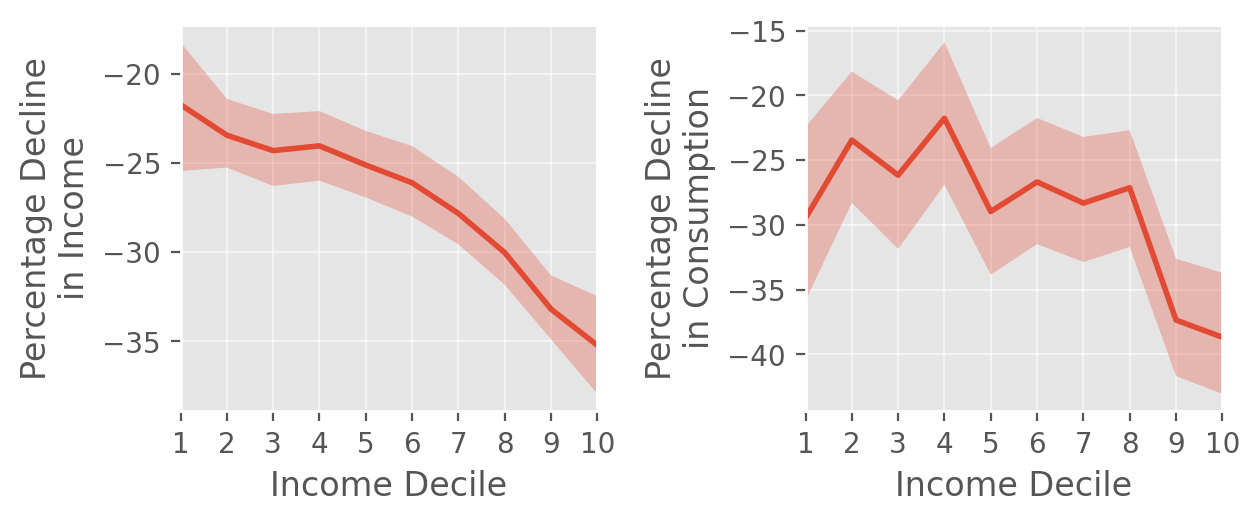

In [30]:
deciles = np.arange(1, 11)

plt.subplot(221)
plt.plot(deciles, 100*coef_income_mean)
plt.fill_between(deciles, 100*coef_income_q10, 100*coef_income_q90, alpha=0.3)
plt.xticks(deciles)
plt.xlabel('Income Decile')
plt.ylabel('Percentage Decline\nin Income')

plt.subplot(222)
plt.plot(deciles, 100*coef_consumption_mean)
plt.fill_between(deciles, 100*coef_consumption_q10, 100*coef_consumption_q90, alpha=0.3)
plt.xticks(deciles)
plt.xlabel('Income Decile')
plt.ylabel('Percentage Decline\nin Consumption');

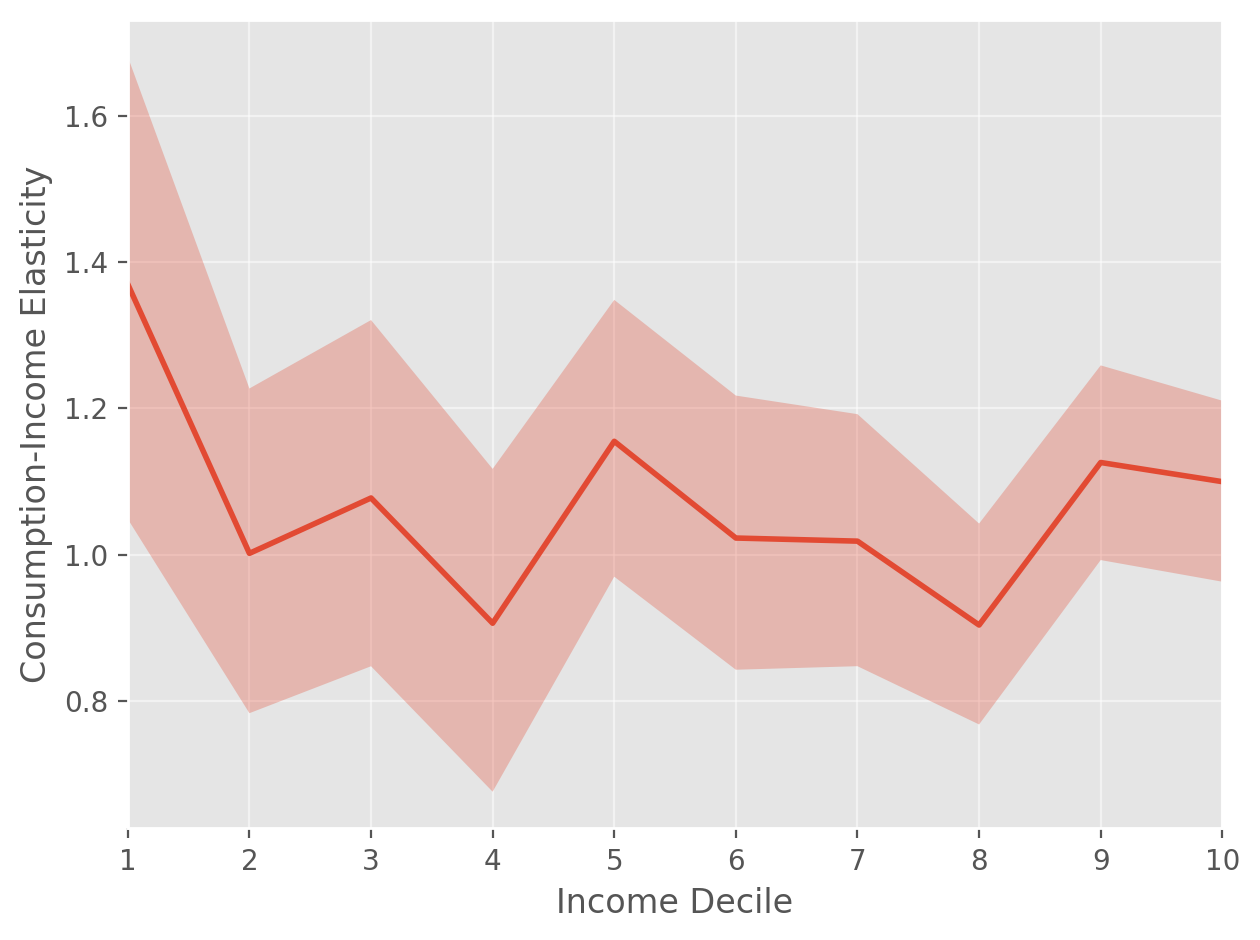

In [31]:
plt.plot(deciles, coef_elasticity_mean)
plt.fill_between(deciles, coef_elasticity_q10, coef_elasticity_q90, alpha=0.3)
plt.ylabel('Consumption-Income Elasticity')

plt.xticks(deciles)
plt.xlabel('Income Decile');